## データセットを訓練データとテストデータに分割する

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

# データセット読み込み
wine = load_wine()

# 特徴量をデータフレームに変換
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)

# クラスラベルを追加
df_wine['target'] = wine.target

# 確認
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [2]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values
# データセットをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

stratify=yを渡すことで、訓練データセットとテストデータセットのクラスの比率が元データセットと同じになる

## 特徴量のスケーリング
多くの機械学習アルゴリズムには標準化の方が実用的かも

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Min-Maxスケーリング
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)
# 標準化
standard_scaler = StandardScaler()
X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

## 意味のある特徴量の選択

### 正則化
scikit-learnの正則化モデルはL1正則化をサポートしている。

In [4]:
from sklearn.linear_model import LogisticRegression
# L1正則化ロジスティック回帰モデルの作成
lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
lr.fit(X_train_std, y_train)
print("Training accuracy:", lr.score(X_train_std, y_train))
print("Test accuracy:", lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


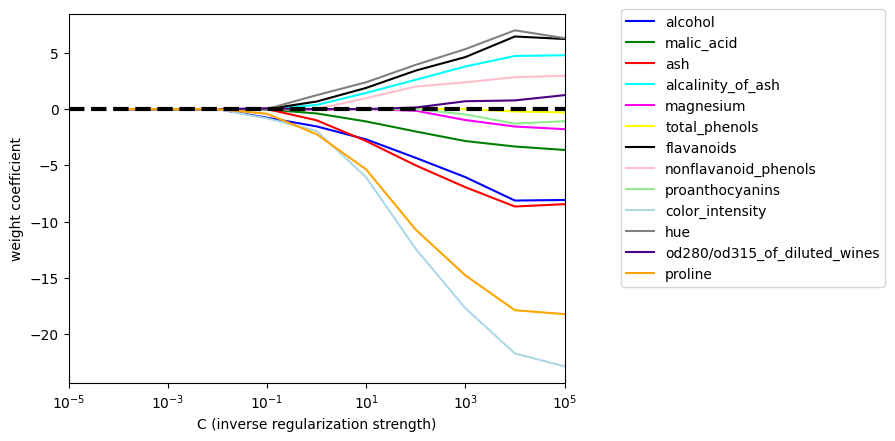

In [5]:
import matplotlib.pyplot as plt
# 描画の準備
fig = plt.figure()
ax = plt.subplot(111)
# 各係数の色のリスト
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']
# 空のリストを作成
weights, params = [], []
# 逆正規化パラメータの値ごとに処理
for c in np.arange(-4., 6.):
    # L1正則化ロジスティック回帰モデルの作成
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear',
                            random_state=0)
    lr.fit(X_train_std, y_train)
    # 重みを取得
    weights.append(lr.coef_[1])
    params.append(10.**c)

# 重みをNumPy配列に変換
weights = np.array(weights)
# 重み係数をプロット
for column, color in zip(range(weights.shape[1]), colors):
    ax.plot(params, weights[:, column], label=df_wine.columns[column],
            color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

特徴量選択における次元削減法は、主に特徴量選択と特徴量抽出の2つのカテゴリに分かれている。

### 逐次特徴量選択アルゴリズム
#### 逐次後退選択(sequential backward selection:SBS)
元々の特徴量空間の次元を減らすことが目的。

In [6]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS:
    """
    逐次後退選択（Sequential Backward Selection）を実行するクラス
    """

    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring  # 特徴量を評価する指標
        self.estimator = clone(estimator)  # 推定器
        self.k_features = k_features  # 選択する特徴量の個数
        self.test_size = test_size  # テストデータの割合
        self.random_state = random_state  # 乱数シードを固定するrandom_state

    def fit(self, X, y):
        # 訓練データとテストデータに分割
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state)

        # すべての特徴量の個数、列インデックス
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]

        # すべての特徴量を用いてスコアを算出
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]  # スコアを格納

        # 特徴量数が指定した個数になるまで処理を繰り返す
        while dim > self.k_features:
            scores = []
            subsets = []

            # 特徴量の部分集合を列インデックスの組み合わせとして作成
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            # 最も高いスコアの部分集合を選択
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            self.scores_.append(scores[best])

            dim -= 1  # 次のステップへ

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        # 特定の特徴量のみを用いてモデルを訓練・評価
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        return self.scoring(y_test, y_pred)


In [7]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
# KNN分類器を使用して逐次後退選択を実行
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

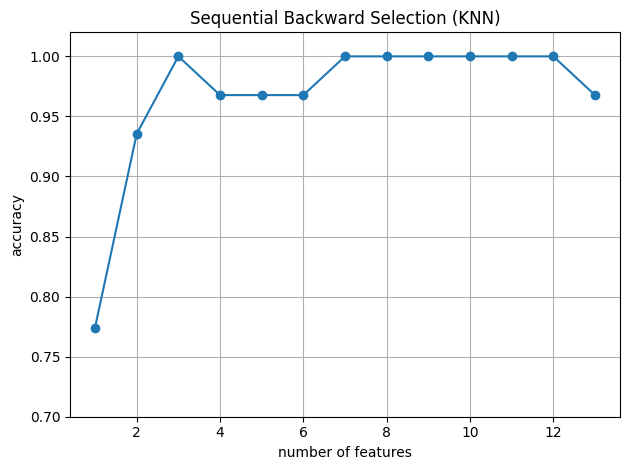

In [8]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('accuracy')
plt.xlabel('number of features')
plt.grid()
plt.title('Sequential Backward Selection (KNN)')
plt.tight_layout()
plt.show()

## ランダムフォレストで特徴量の重要度を評価
便利な方法であるが、2つ以上の特徴量の相関が強い場合、1つの特徴量のランクは非常に高かったとしても、残りの特徴量の重要度はランクに十分に反映されていないかもしれない。一方で、特徴量の重要度の解釈よりもモデルの予想性能に関心があるだけなら、この問題について気にする必要はない。

 1) proline              0.185
 2) flavanoids           0.175
 3) color_intensity      0.144
 4) od280/od315_of_diluted_wines 0.136
 5) alcohol              0.119
 6) hue                  0.059
 7) total_phenols        0.051
 8) magnesium            0.031
 9) malic_acid           0.026
10) proanthocyanins      0.026
11) alcalinity_of_ash    0.022
12) nonflavanoid_phenols 0.013
13) ash                  0.013


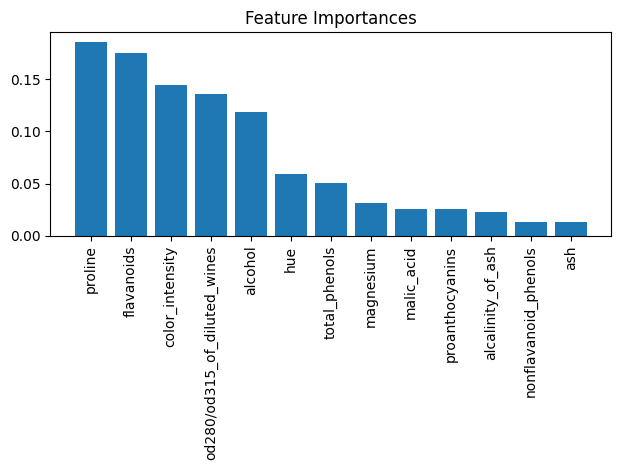

In [9]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[:-1]

# ランダムフォレスト分類器を使用して特徴量の重要度を計算
forest = RandomForestClassifier(n_estimators=500, random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
# 特徴量の重要度を取得
importances = forest.feature_importances_
# 特徴量の重要度を降順にソート
indices = np.argsort(importances)[::-1] # [::-1] は Python のスライス構文 で、「リストを逆順にする」

for f in range(X_train.shape[1]):
    print(f"{f + 1:2d}) {feat_labels[indices[f]]:20s} {importances[indices[f]]:.3f}")

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

前処理ステップとしての絞り込み

In [10]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
# 選択された特徴量のインデックスを取得
X_selected = sfm.transform(X_train)
print("Selected features shape:", X_selected.shape[1])

for f in range(X_selected.shape[1]):
    print(f"{f + 1:2d}) {feat_labels[indices[f]]:20s} {importances[indices[f]]:.3f}")

Selected features shape: 5
 1) proline              0.185
 2) flavanoids           0.175
 3) color_intensity      0.144
 4) od280/od315_of_diluted_wines 0.136
 5) alcohol              0.119
